# Задача теплопроводности

Запишем явную разностную схему:

$$
\frac{\theta_{x, y}^{n + 1} - \theta_{x, y}^n}{\Delta t} = \frac{\theta_{x + 1, y}^n + \theta_{x, y+1}^n - 4 \theta_{x, y}^n + \theta_{x-1, y}^n + \theta_{x, y-1}^n}{h^2}
$$

In [2]:
import numba
import numpy as np
from tqdm.notebook import tqdm
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader

sns.set(font_scale=1.4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Разностная схема:

In [0]:
def get_next_step(theta, h, tau):
    """
    theta --- (N + 1, N + 1) array
    h --- space step
    tau --- time step
    """

    N = len(theta) - 1
    x_index = np.repeat(np.arange(1, N)[:, np.newaxis], 
                                N-1, axis=1)
    y_index = np.repeat(np.arange(1, N)[np.newaxis, :], 
                            N-1, axis=0)
    
    vicinity = theta[x_index + 1, y_index] + theta[x_index, y_index + 1] + \
               theta[x_index - 1, y_index] + theta[x_index, y_index -1]
    
    right_side = (vicinity - 4 * theta[x_index, y_index]) * tau / h ** 2
    theta[x_index, y_index] += right_side

    return theta

N = 100

X = np.linspace(-1, 1, N + 1)
Y = np.linspace(-1, 1, N + 1)



X, Y = np.meshgrid(X, Y)

theta = np.sin(X + Y ** 2)
theta[1:N, 1:N] = 0

Запишем ход движения и сохраним:

In [4]:
history = np.zeros((3 * 10 ** 4, N + 1, N + 1))
print_every = 1

for i in tqdm(range(3 * 10 ** 4)):
    if (i % print_every == 0):
        history[i // print_every] = theta
    theta = get_next_step(theta, 2 / N, 0.4 / N ** 2)

In [0]:
np.save('/content/drive/My Drive/NN_PDE_SPEEDUP/Heat_proccess/history.npy',
        history
        )

In [0]:
history = np.load(
    '/content/drive/My Drive/NN_PDE_SPEEDUP/Heat_proccess/history.npy'
    )

Псомтрим, как решение выглядит в зависимости от времени:

In [0]:
def plot(index):
    plt.figure(figsize=(8, 8))
    sns.heatmap(history[index])
    plt.show()

In [8]:
interact(plot, index=(0, 30000 - 1))

interactive(children=(IntSlider(value=14999, description='index', max=29999), Output()), _dom_classes=('widget…

<function __main__.plot>

Отлично, у нас есть данные, попробуем обучить LSTM. Вопрос: сможем ли мы предсказть довольно простую динамику по первым 3000 объектов.

Преобрузуем данные. Будем сжимать с помощью PCA:

In [9]:
PCA_list = []
archived_history = np.zeros((30000, 10))

for i in tqdm(range(0, 30000 - 500, 500)):
    new_pca = PCA(n_components=10)
    archived_history[i:i+500] = \
        new_pca.fit_transform(history[i:i + 500].reshape(-1, (N + 1) * (N + 1)))
    PCA_list.append(new_pca)

Посмотрим на невязку:

In [10]:
result = PCA_list[0].inverse_transform(archived_history[20])
result = result.reshape(-1, N + 1, N + 1)
np.max(np.abs(result - history[20])) / np.max(np.abs(history[20]))

0.0002635814859925365

Неплохой результат.

Создадим класс самой простой модели. HiddenState в нашем случае мы поставили равным 100.

In [0]:
class SimpleModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.rnn = nn.LSTM(10, 100)
        self.decoder = nn.Linear(100, 10)

    def forward(self, seq, hidden=None):
        output, last_hidden = self.rnn(seq, hidden)
        return self.decoder(output), last_hidden


In [0]:
model = SimpleModel().double().cuda()

Зададим параметры обучения:

In [0]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

In [0]:
train = torch.from_numpy(archived_history[:1500]).cuda()
val = torch.from_numpy(archived_history[1500:3000]).cuda()
test = torch.from_numpy(archived_history[3000:]).cuda()

train_loss = []
val_loss = []

In [15]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    output, last_hidden = model(train[:-1].view(-1, 1, 10))
    loss = loss_func(output.view(-1, 10), train[1:])
    train_loss.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()

    output, _ = model(val[:-1].view(-1, 1, 10), last_hidden)

    loss = loss_func(output.view(-1, 10), val[1:])
    val_loss.append(loss.item())

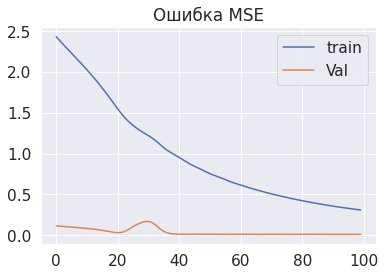

In [16]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='Val')
plt.title('Ошибка MSE')
plt.legend()
plt.show()

Невязка на валидационном датасете:

In [0]:
val_results = output.view(-1, 10).cpu().detach().numpy()
reshaped_results = np.zeros((5000, (N + 1) * (N + 1)))

new_output = val[0].view(-1, 1, 10)
new_hidden = last_hidden

for i in range(5000):
    new_output, new_hidden = model(new_output, new_hidden)
    reshaped_results[i] = \
        PCA_list[(1500 + i) // 500].inverse_transform(
            new_output.cpu().detach().numpy().reshape(1, -1)
            )[0]


reshaped_results = reshaped_results.reshape(-1, N + 1, N + 1)  

In [0]:
def plot(index):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.title('Предсказание LSTM')
    sns.heatmap(reshaped_results[index])
    tol = np.max(np.abs(reshaped_results[index] - reshaped_results[index + 1]))/\
            np.max(np.abs(reshaped_results[index + 1]))
    print('Текущая невязка LSTM: ', tol)

    plt.subplot(1, 2, 2)
    plt.title('Истинная функция')
    sns.heatmap(history[1500 + index])
    plt.show()

Сохраним резльтат, чтобы потом его показать:

In [0]:
for i in range(0, 4999, 100):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.title(f'Предсказание LSTM {i}')
    sns.heatmap(reshaped_results[i])

    plt.subplot(1, 2, 2)
    plt.title(f'Истинная функция {i}')
    sns.heatmap(history[1500 + i])
    plt.savefig(
        f'/content/drive/My Drive/NN_PDE_SPEEDUP/Animated_Heat/step_{i}'
        )
    plt.close()

In [20]:
interact(plot, index=(0, 4998, 100))

interactive(children=(IntSlider(value=2400, description='index', max=4998, step=100), Output()), _dom_classes=…

<function __main__.plot>

Невязка LSTM:

In [0]:
tol_list = []

for index in range(4999):
    tol_list.append(
        np.max(np.abs(reshaped_results[index] - reshaped_results[index + 1]))/
        np.max(np.abs(reshaped_results[index + 1]))
    )

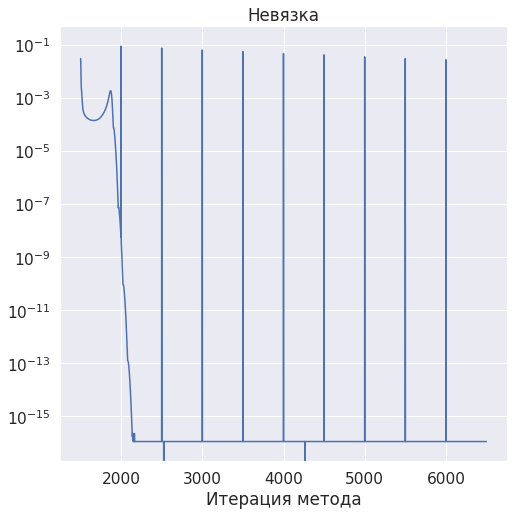

In [25]:
plt.figure(figsize=(8,8))
plt.semilogy(np.arange(1500, 6500 - 1), tol_list)
plt.title('Невязка')
plt.xlabel('Итерация метода')
plt.show()

Как видим, невязка выдает довльно странные результаты. В момент смены PCA она подскакивает до 0.1, но после идет своим ходом. Здесь она рассчитывалась как максимум абсолютной разности между предыдущим и последующим шагами, деленная на их 